In [16]:
import threading
import torch
import random
import os
import scanpy as sc
import pandas as pd
import numpy as np
import scipy

max_connections = 5 # 定义最大线程数
pool_sema = threading.Semaphore(max_connections) # 使用Semaphore方法
pool_sema.acquire() # 加锁，限制线程数


#os.environ["CUDA_VISIBLE_DEVICES"] = '2'
torch.cuda.set_device(0)
device = torch.device("cuda:0")


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
setup_seed(42)

In [2]:
adata_seqfish = sc.read_h5ad('/data/msyuan/Datasets/Multi-Omics-Datasets/MouseGastrulationData/adata_seqfish.h5ad')
print("adata_seqfish:",adata_seqfish, np.unique(adata_seqfish.obs['cell_type']))
adata_rna = sc.read_h5ad('/data/msyuan/Datasets/Multi-Omics-Datasets/MouseGastrulationData/adata_rna.h5ad')
print("adata_rna:",adata_rna, np.unique(adata_rna.obs['cell_type']))

adata_seqfish: AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'cell_type', 'domain_id', 'source', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine' ['Allantois' 'Anterior somitic tissues' 'Blood progenitors'
 'Cardiomyocytes' 'Cranial mesoderm' 'Definitive endoderm' 'Dermomyotome'
 'Endothelium' 'Erythroid' 'ExE endoderm' 'Forebrain/Midbrain/Hindbrain'
 'Gut tube' 'Haematoendothelial progenitors' 'Intermediate mesoderm'
 'Lateral plate mesoderm' 'Low quality' 'Mixed mesenchymal mesoderm' 'NMP'
 'Neural crest' 'Presomitic mesoderm' 'Sclerotome' 'Spinal cord'
 'Splanchnic mesoderm' 'Surface ectoderm']
adata_rna: AnnData object with n_obs × n_vars = 116312 × 29452
    obs: 'batch', 'cell_type', 'domain_id', 'source' ['Allantois' 'Anterior Primitive Streak' 'Blood progenitors 1'
 'Blood progenitors 2' 'Cardiomyocytes' 'Caudal Mesoderm'
 'Caudal epiblast' 'Caudal neurectoderm' 'Def. endoderm' 'Endothelium'
 'Epiblast' 'Erythroid1' 'Erythroid2' 'Erythroid3' 'ExE ectoder

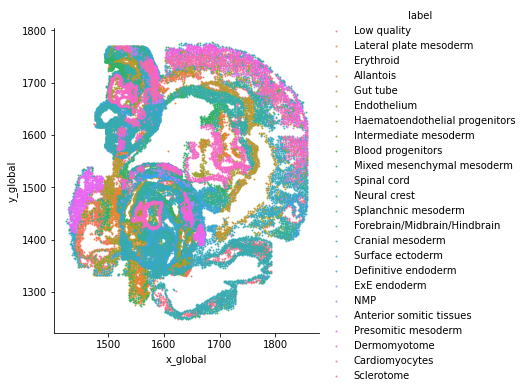

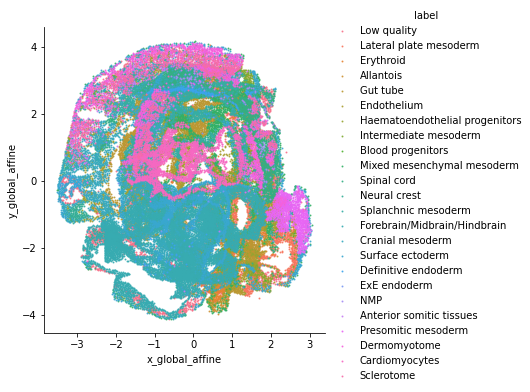

In [3]:
import seaborn as sns
seqfish_coor = pd.DataFrame()
seqfish_coor['x_global'] = adata_seqfish.obs['x_global'] 
seqfish_coor['y_global'] = adata_seqfish.obs['y_global'] 
seqfish_coor['x_global_affine'] = adata_seqfish.obs['x_global_affine'] 
seqfish_coor['y_global_affine'] = adata_seqfish.obs['y_global_affine'] 
plot_seqfish = seqfish_coor
plot_seqfish['label']=np.array(adata_seqfish.obs['cell_type'])
sns.lmplot(data=plot_seqfish, x='x_global', y='y_global',hue='label',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
sns.lmplot(data=plot_seqfish, x='x_global_affine', y='y_global_affine',hue='label',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})

In [4]:
common_cell_type=[i for i in np.unique(adata_rna.obs['cell_type']) if i in np.unique(adata_seqfish.obs['cell_type'])]
rna_private_cell_type=[i for i in np.unique(adata_rna.obs['cell_type']) if i not in np.unique(adata_seqfish.obs['cell_type'])]
seqfish_private_cell_type=[i for i in np.unique(adata_seqfish.obs['cell_type']) if i not in np.unique(adata_rna.obs['cell_type'])]
print("common_cell_type:",common_cell_type)
print("rna_private_cell_type:",rna_private_cell_type)
print("seqfish_private_cell_type:",seqfish_private_cell_type)
rna_preserve_index=[i in common_cell_type for i in adata_rna.obs['cell_type']]
seqfish_preserve_index=[i in common_cell_type for i in adata_seqfish.obs['cell_type']] 
adata_rna = adata_rna[rna_preserve_index]
adata_seqfish = adata_seqfish[seqfish_preserve_index]
seqfish_coor = seqfish_coor[seqfish_preserve_index]

print("adata_seqfish:",adata_seqfish, np.unique(adata_seqfish.obs['cell_type'],return_counts=True))
print("adata_rna:",adata_rna, np.unique(adata_rna.obs['cell_type'],return_counts=True))

common_cell_type: ['Allantois', 'Cardiomyocytes', 'Endothelium', 'ExE endoderm', 'Forebrain/Midbrain/Hindbrain', 'Haematoendothelial progenitors', 'Intermediate mesoderm', 'NMP', 'Neural crest', 'Spinal cord', 'Surface ectoderm']
rna_private_cell_type: ['Anterior Primitive Streak', 'Blood progenitors 1', 'Blood progenitors 2', 'Caudal Mesoderm', 'Caudal epiblast', 'Caudal neurectoderm', 'Def. endoderm', 'Epiblast', 'Erythroid1', 'Erythroid2', 'Erythroid3', 'ExE ectoderm', 'ExE mesoderm', 'Gut', 'Mesenchyme', 'Mixed mesoderm', 'Nascent mesoderm', 'Notochord', 'PGC', 'Paraxial mesoderm', 'Parietal endoderm', 'Pharyngeal mesoderm', 'Primitive Streak', 'Rostral neurectoderm', 'Somitic mesoderm', 'Visceral endoderm']
seqfish_private_cell_type: ['Anterior somitic tissues', 'Blood progenitors', 'Cranial mesoderm', 'Definitive endoderm', 'Dermomyotome', 'Erythroid', 'Gut tube', 'Lateral plate mesoderm', 'Low quality', 'Mixed mesenchymal mesoderm', 'Presomitic mesoderm', 'Sclerotome', 'Splanchn

In [5]:
adata_cm = adata_seqfish.concatenate(adata_rna, join='inner', batch_key='domain_id')
print(adata_cm,adata_cm.obs)

# construct labels
labels = np.zeros(len(adata_cm))
cell_types = np.unique(adata_cm.obs["cell_type"])
type_nums = np.arange(len(adata_cm))
adata_cm.obs["label"] = adata_cm.obs["cell_type"]
for i in range(len(cell_types)):
    labels[adata_cm.obs["label"]==cell_types[i]] = type_nums[i]
labels = np.asarray(labels, dtype=int)
adata_cm.obs["labels"] = labels
rna_labels = labels[adata_cm.obs["domain_id"]=='1']
seqfish_labels = labels[adata_cm.obs["domain_id"]=='0']

/data/msyuan/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 62121 × 351
    obs: 'cell_type', 'domain_id', 'source', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'batch'                                                 cell_type domain_id   source  \
embryo1_Pos0_cell101_z5-0                       Allantois         0  seqFISH   
embryo1_Pos0_cell102_z5-0                     Endothelium         0  seqFISH   
embryo1_Pos0_cell106_z2-0  Haematoendothelial progenitors         0  seqFISH   
embryo1_Pos0_cell108_z2-0                       Allantois         0  seqFISH   
embryo1_Pos0_cell11_z5-0            Intermediate mesoderm         0  seqFISH   
...                                                   ...       ...      ...   
cell_139317-1-1                            Cardiomyocytes         1      RNA   
cell_139319-1-1              Forebrain/Midbrain/Hindbrain         1      RNA   
cell_139322-1-1              Forebrain/Midbrain/Hindbrain         1      RNA   
cell_139323-1-1                     

In [6]:
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler


def batch_scale(adata, use_rep='X', chunk_size=20000):
    """
    Batch-specific scale data

    Parameters
    ----------
    adata
        AnnData
    use_rep
        use '.X' or '.obsm'
    chunk_size
        chunk large data into small chunks

    """
    for b in adata.obs['source'].unique():
        idx = np.where(adata.obs['source'] == b)[0]
        if use_rep == 'X':
            scaler = MaxAbsScaler(copy=False).fit(adata.X[idx])
            for i in range(len(idx) // chunk_size + 1):
                adata.X[idx[i * chunk_size:(i + 1) * chunk_size]] = scaler.transform(
                    adata.X[idx[i * chunk_size:(i + 1) * chunk_size]])
        else:
            scaler = MaxAbsScaler(copy=False).fit(adata.obsm[use_rep][idx])
            for i in range(len(idx) // chunk_size + 1):
                adata.obsm[use_rep][idx[i * chunk_size:(i + 1) * chunk_size]] = scaler.transform(
                    adata.obsm[use_rep][idx[i * chunk_size:(i + 1) * chunk_size]])


sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
batch_scale(adata_cm)

sc.pp.normalize_total(adata_seqfish)
sc.pp.log1p(adata_seqfish)
sc.pp.highly_variable_genes(adata_seqfish, n_top_genes=2000, inplace=False, subset=True)
batch_scale(adata_seqfish)

sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
batch_scale(adata_rna)

/data/msyuan/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
# network structure
import math
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.autograd import Function

activation = {
    'relu': nn.ReLU(),
    'rrelu': nn.RReLU(),
    'sigmoid': nn.Sigmoid(),
    'leaky_relu': nn.LeakyReLU(),
    'tanh': nn.Tanh(),
    '': None
}


class DSBatchNorm(nn.Module):
    """
    Domain-specific Batch Normalization
    """

    def __init__(self, num_features, n_domain, eps=1e-5, momentum=0.1):
        """
        Parameters
        ----------
        num_features
            dimension of the features
        n_domain
            domain number
        """
        super().__init__()
        self.n_domain = n_domain
        self.num_features = num_features
        self.bns = nn.ModuleList([nn.BatchNorm1d(num_features, eps=eps, momentum=momentum) for i in range(n_domain)])

    def reset_running_stats(self):
        for bn in self.bns:
            bn.reset_running_stats()

    def reset_parameters(self):
        for bn in self.bns:
            bn.reset_parameters()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, x, y):
        out = torch.zeros(x.size(0), self.num_features, device=x.device)  # , requires_grad=False)
        for i in range(self.n_domain):
            indices = np.where(y.cpu().numpy() == i)[0]

            if len(indices) > 1:
                out[indices] = self.bns[i](x[indices])
            elif len(indices) == 1:
                # out[indices] = x[indices]
                self.bns[i].training = False
                out[indices] = self.bns[i](x[indices])
                self.bns[i].training = True
        return out


class Block(nn.Module):
    """
    Basic block consist of:
        fc -> bn -> act -> dropout
    """

    def __init__(
            self,
            input_dim,
            output_dim,
            norm='',
            act='',
            dropout=0
    ):
        """
        Parameters
        ----------
        input_dim
            dimension of input
        output_dim
            dimension of output
        norm
            batch normalization,
                * '' represent no batch normalization
                * 1 represent regular batch normalization
                * int>1 represent domain-specific batch normalization of n domain
        act
            activation function,
                * relu -> nn.ReLU
                * rrelu -> nn.RReLU
                * sigmoid -> nn.Sigmoid()
                * leaky_relu -> nn.LeakyReLU()
                * tanh -> nn.Tanh()
                * '' -> None
        dropout
            dropout rate
        """
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

        if type(norm) == int:
            if norm == 1:  # TO DO
                self.norm = nn.BatchNorm1d(output_dim)
            else:
                self.norm = DSBatchNorm(output_dim, norm)
        else:
            self.norm = None

        self.act = activation[act]

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

    def forward(self, x, y=None):
        h = self.fc(x)
        if self.norm:
            if len(x) == 1:
                pass
            elif self.norm.__class__.__name__ == 'DSBatchNorm':
                h = self.norm(h, y)
            else:
                h = self.norm(h)
        if self.act:
            h = self.act(h)
        if self.dropout:
            h = self.dropout(h)
        return h


class NN(nn.Module):
    """
    Neural network consist of multi Blocks
    """

    def __init__(self, input_dim, cfg):
        """
        Parameters
        ----------
        input_dim
            input dimension
        cfg
            model structure configuration, 'fc' -> fully connected layer

        Example
        -------
        >>> latent_dim = 10
        >>> dec_cfg = [['fc', x_dim, n_domain, 'sigmoid']]
        >>> decoder = NN(latent_dim, dec_cfg)
        """
        super().__init__()
        net = []
        for i, layer in enumerate(cfg):
            if i == 0:
                d_in = input_dim
            if layer[0] == 'fc':
                net.append(Block(d_in, *layer[1:]))
            d_in = layer[1]
        self.net = nn.ModuleList(net)

    def forward(self, x, y=None):
        for layer in self.net:
            x = layer(x, y)
        return x


class Encoder(nn.Module):
    """
    VAE Encoder
    """

    def __init__(self, input_dim, cfg):
        """
        Parameters
        ----------
        input_dim
            input dimension
        cfg
            encoder configuration, e.g. enc_cfg = [['fc', 1024, 1, 'relu'],['fc', 10, '', '']]
        """
        super().__init__()

        enc = []
        mu_enc = []
        var_enc = []

        h_dim = cfg[-2][1]

        enc.append(NN(input_dim[0], cfg[:-1]))
        mu_enc.append(NN(h_dim, cfg[-1:]))
        var_enc.append(NN(h_dim, cfg[-1:]))

        self.enc = nn.ModuleList(enc)
        self.mu_enc = nn.ModuleList(mu_enc)
        self.var_enc = nn.ModuleList(var_enc)

    def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()

    def forward(self, x, domain, y=None):
        """
        """
        q = self.enc[domain](x, y)
        mu = self.mu_enc[domain](q, y)
        var = torch.exp(self.var_enc[domain](q, y))
        z = self.reparameterize(mu, var)
        return z, mu, var


class Decoder(nn.Module):
    """
    VAE Decoder
    """

    def __init__(self, z_dim, cfg):
        """
        Parameters
        ----------
        z_dim
            latent dimension
        cfg
            decoder configuration, e.g. dec_cfg = [['fc', adatas[i].obsm[obsm[i]].shape[1], 1, 'sigmoid']]
        """
        super().__init__()

        dec = []
        for i in cfg.keys():
            dec.append(NN(z_dim, cfg[i]))

        self.dec = nn.ModuleList(dec)

    def forward(self, z, domain, y=None):
        """
        """
        reconx_x = self.dec[domain](z, y)

        return reconx_x


class ProtoCLS(nn.Module):
    """
    prototype-based classifier
    L2-norm + a fc layer (without bias)
    """

    def __init__(self, in_dim, out_dim, temp=0.05):
        super(ProtoCLS, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.tmp = temp
        self.weight_norm()

    def forward(self, x):
        x = F.normalize(x)
        x = self.fc(x) / self.tmp
        return x

    def weight_norm(self):
        w = self.fc.weight.data
        norm = w.norm(p=2, dim=1, keepdim=True)
        self.fc.weight.data = w.div(norm.expand_as(w))


class CLS(nn.Module):
    """
    a classifier made up of projection head and prototype-based classifier
    """

    def __init__(self, in_dim, out_dim, hidden_mlp=1024, feat_dim=16, temp=0.05):
        super(CLS, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(in_dim, hidden_mlp),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_mlp, feat_dim))
        self.ProtoCLS = ProtoCLS(feat_dim, out_dim, temp)

    def forward(self, x):
        before_lincls_feat = self.projection_head(x)
        after_lincls = self.ProtoCLS(before_lincls_feat)
        return before_lincls_feat, after_lincls

In [8]:
import ot
# author: Musu Yuan
# modified from UniOT for UniDA(NIPS2022)

def ubot_CCD(sim, beta, stopThr=1e-4):
    # fake_size (Adaptive filling) + fill_size (memory queue filling) + mini-batch size
    M = -sim
    alpha = ot.unif(sim.size(0))
    Q_st = ot.unbalanced.sinkhorn_knopp_unbalanced(alpha, beta, M.detach().cpu().numpy(),
                                                   reg=0.01, reg_m=0.5, stopThr=stopThr)
    Q_st = torch.from_numpy(Q_st).float().cuda()

    # make sum equals to 1
    sum_pi = torch.sum(Q_st)
    Q_st_bar = Q_st / sum_pi
    # confidence score w^t_i
    wt_i, pseudo_label = torch.max(Q_st_bar, 1)

    new_beta = torch.sum(Q_st_bar, 0).cpu().numpy()

    return pseudo_label, new_beta, Q_st_bar, wt_i

In [9]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True, reduction=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.reduction = reduction
        self.logsoftmax = nn.LogSoftmax(dim=1)  # 对每一行的所有元素进行softmax运算，并使得每一行所有元素和为1，再取log.

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).cpu(), 1)  #

        if self.use_gpu: targets = targets.cuda()
        targets = (1 -
                   self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (-targets * log_probs).sum(dim=1)  # 对行求和，消掉列，keepdim=True则列变成1
        if self.reduction:
            return loss.mean()
        else:
            return loss
        return loss

In [10]:
#### OT Loss
#!/usr/bin/env 
"""
# Author: Kai Cao
# Modified from RAE
"""
from torch.distributions import Normal, kl_divergence

def kl_div(mu, var, weight=None):
    loss = kl_divergence(Normal(mu, var.sqrt()), Normal(torch.zeros_like(mu),torch.ones_like(var))).sum(dim=1)
    
    # if weight is not None:
    #     loss = loss * weight.squeeze(dim=1)
    return loss.mean()
 
# def balanced_binary_cross_entropy(recon_x, x):

#     return -torch.sum(x * torch.log(recon_x + 1e-8) + (1 - x) * torch.log(1 - recon_x + 1e-8), dim=-1)

def distance_matrix(pts_src: torch.Tensor, pts_dst: torch.Tensor, p: int = 2):
    """
    Returns the matrix of ||x_i-y_j||_p^p.

    """
    x_col = pts_src.unsqueeze(1)
    y_row = pts_dst.unsqueeze(0)
    distance = torch.sum((torch.abs(x_col - y_row)) ** p, 2)
    return distance

def distance_gmm(mu_src: torch.Tensor, mu_dst: torch.Tensor, var_src: torch.Tensor, var_dst: torch.Tensor):
    """
    Calculate a Wasserstein distance matrix between the gmm distributions with diagonal variances
    
    """
    std_src = var_src.sqrt()
    std_dst = var_dst.sqrt()
    distance_mean = distance_matrix(mu_src, mu_dst, p=2)
    distance_var = distance_matrix(std_src, std_dst, p=2)

    # distance_var = torch.sum(sum_matrix(std_src, std_dst) - 2 * (prod_matrix(std_src, std_dst) ** 0.5), 2)
    
    return distance_mean + distance_var 

def pdists(A, squared = False, eps = 0):
    prod = torch.mm(A, A.t())
    norm = prod.diag().unsqueeze(1).expand_as(prod)
    res = (norm + norm.t() - 2 * prod).clamp(min = 0)
    
    if squared:
        return res
    else:
        res = res.clamp(min = eps).sqrt()
        return res

In [11]:
adatas = [adata_seqfish, adata_rna]
num_cell = []
num_gene = []
for i, adata in enumerate(adatas):
    num_cell.append(adata.X.shape[0])
    num_gene.append(adata.X.shape[1])

n_domain = len(adatas)
enc = [['fc', 1024, 1, 'relu'], ['fc', 16, '', '']]
num_gene.append(adata_cm.X.shape[1])
dec = {}
dec[0] = [['fc', num_gene[n_domain], n_domain, 'sigmoid']]  # common decoder
for i in range(1, n_domain + 1):
    dec[i] = [['fc', num_gene[i - 1], 1, 'sigmoid']]  # dataset-specific decoder

x_dim = {}
for key in dec.keys():
    x_dim[key] = dec[key][-1][1]
    z_dim = enc[-1][1]

source_classes = list(np.unique(adata_rna.obs["cell_type"]))
print("source_classes:", source_classes)
target_classes = list(np.unique(adata_seqfish.obs["cell_type"]))
print("target_classes:", target_classes)
target_private_classes = []
for i in range(len(target_classes)):
    if target_classes[i] not in source_classes:
        target_private_classes.append(target_classes[i])
print("target_private_classes:", target_private_classes)

feat_dim = 32

source_classes: ['Allantois', 'Cardiomyocytes', 'Endothelium', 'ExE endoderm', 'Forebrain/Midbrain/Hindbrain', 'Haematoendothelial progenitors', 'Intermediate mesoderm', 'NMP', 'Neural crest', 'Spinal cord', 'Surface ectoderm']
target_classes: ['Allantois', 'Cardiomyocytes', 'Endothelium', 'ExE endoderm', 'Forebrain/Midbrain/Hindbrain', 'Haematoendothelial progenitors', 'Intermediate mesoderm', 'NMP', 'Neural crest', 'Spinal cord', 'Surface ectoderm']
target_private_classes: []


In [12]:
# dataloader
from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler


class SingleCellDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.shape = data.shape

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx].toarray().squeeze()
        labels = self.labels[idx].squeeze()

        return x, labels, idx


adata_cm_rna = adata_cm[adata_cm.obs["domain_id"] == '1']
adata_cm_seqfish = adata_cm[adata_cm.obs["domain_id"] == '0']
source_cm_ds = SingleCellDataset(adata_cm_rna.X, rna_labels)
target_cm_ds = SingleCellDataset(adata_cm_seqfish.X, seqfish_labels)
source_sp_ds = SingleCellDataset(adata_rna.X, rna_labels)
target_sp_ds = SingleCellDataset(adata_seqfish.X, seqfish_labels)

batch_size = 256
num_workers = 4
classes = rna_labels
freq = Counter(classes)
class_weight = {x: 1.0 / freq[x] for x in freq}
source_weights = [class_weight[x] for x in classes]
sampler = WeightedRandomSampler(source_weights, len(source_cm_ds.labels))

source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=batch_size,
                          sampler=sampler, num_workers=num_workers, drop_last=True)
target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, drop_last=True)
test_source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=batch_size,
                               sampler=sampler, num_workers=num_workers, drop_last=False)
test_target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, drop_last=False)
# output: x, domain_id, idx

In [13]:
import torch.nn.functional as F
from torch.distributions import Beta
from torch.distributions import Normal, kl_divergence
from easydl import AccuracyCounter, one_hot, variable_to_numpy, clear_output

torch.cuda.current_device()
torch.cuda._initialized = True
class_num = len(source_classes)
lambda_recon = 2000
lambda_kl = 0.5
lambda_spa = 0.2
lambda_cd = 0.1
lambda_nb = 100.0

beta = None
beta_s = ot.unif(class_num)
mu = 0.6
gamma = 0.6
temp = 0.1
k = 20

maxiter = 7000
miditer1 = 3000
miditer2 = 6000
miditer3 = 5000
iteration = 0
test_freq = 1000


# nueral networks
encoder = Encoder(x_dim, enc).cuda()
decoder = Decoder(z_dim, dec).cuda()
classifier = CLS(z_dim, len(source_classes)).cuda()

optim_enc = torch.optim.Adam(encoder.parameters(), lr=2e-4, weight_decay=5e-4)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=2e-4, weight_decay=5e-4)
optim_cls = torch.optim.Adam(classifier.parameters(), lr=2e-4, weight_decay=5e-4)

seqfish_coor_new = seqfish_coor[['x_global', 'y_global']]
target_coor = torch.tensor(np.array(seqfish_coor_new)).cuda()
target_coor = torch.tensor(target_coor, dtype=torch.float)
target_coor = target_coor/torch.max(target_coor, axis=0)[0]

while iteration < maxiter:
    iters = zip(source_cm_dl, target_cm_dl)
    for minibatch_id, ((im_source, label_source, id_source), (im_target, label_target, id_target)) in enumerate(iters):

        label_source = label_source.cuda()
        label_target = label_target.cuda()
        im_source = im_source.cuda()
        im_target = im_target.cuda()
        xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
        xs_target = torch.tensor(target_sp_ds[id_target.numpy()][0]).cuda()
        y_source = torch.ones(len(im_source)).long().cuda()
        y_target = torch.zeros(len(im_target)).long().cuda()
        batch_coor = target_coor[id_target]

        z_source, mu_source, var_source = encoder(im_source, 0, y_source)
        z_target, mu_target, var_target = encoder(im_target, 0, y_target)

        recon_source_c = decoder.dec[0](z_source, y_source)
        recon_target_c = decoder.dec[0](z_target, y_target)
        recon_source_s = decoder.dec[2](z_source, y_source)
        recon_target_s = decoder.dec[1](z_target, y_target)

        before_lincls_feat_s, after_lincls_s = classifier(z_source)
        before_lincls_feat_t, after_lincls_t = classifier(z_target)

        norm_feat_s = F.normalize(before_lincls_feat_s)
        norm_feat_t = F.normalize(before_lincls_feat_t)

        # reconstruction loss
        recon_crit = nn.BCELoss()
        recon_loss = torch.tensor(0.0).cuda()

        recon_loss += recon_crit(recon_source_c, im_source) + recon_crit(recon_target_c, im_target)
        recon_loss += 0.5 * (recon_crit(recon_source_s, xs_source) + recon_crit(recon_target_s, xs_target))
        kl_loss = torch.tensor(0.0).cuda()
        kl_loss += kl_div(mu_source, var_source) + kl_div(mu_target, var_target)

        # classification loss
        # criterion = nn.CrossEntropyLoss().cuda()
        criterion = CrossEntropyLabelSmooth(class_num, epsilon=0.1).cuda()
        cls_loss = criterion(after_lincls_s, label_source)
        
        # Spatial alignment loss
        spa_loss = torch.tensor(0.0).cuda()
        if iteration > miditer3:
            spa_dist_mat = distance_gmm(mu_target, mu_target, var_target, var_target)
            spa_dist_mat = spa_dist_mat/torch.max(spa_dist_mat)
            coor_dist_mat = pdists(batch_coor, squared=True)
            coor_dist_mat = coor_dist_mat/torch.max(coor_dist_mat)
            #spa_loss = torch.norm(spa_dist_mat - coor_dist_mat)/batch_size
            index = torch.topk(coor_dist_mat, k=k, largest=False)[1]
            for i in range(batch_size):
                spa_loss += torch.norm(spa_dist_mat[i][index[i]] - coor_dist_mat[i][index[i]])/(k-1)
            spa_loss /= batch_size
        
        # cell type ot alignment
        ccd_loss = torch.tensor(0.0).cuda()
        if iteration > miditer1:
            if beta is None:
                beta = ot.unif(source_prototype.size()[0])
            sim = torch.matmul(norm_feat_t, source_prototype.t())

            # UOT-based CCD
            pseudo_label_t, new_beta, Q_t, wt_i = ubot_CCD(sim, beta)
            pseudo_label_t_soft = Q_t * ((1 / torch.sum(Q_t, 1)).unsqueeze(1).expand(-1, Q_t.size()[1]))
            weight_t = (wt_i-torch.min(wt_i))/(torch.max(wt_i)-torch.min(wt_i))
            # adaptive update for marginal probability vector
            if True not in np.isnan(new_beta):
                beta = mu * beta + (1 - mu) * new_beta
            pred_label_t = torch.argmax(after_lincls_t, axis=1)
            pred_label_t_soft = torch.softmax(after_lincls_t, axis=1)

            if True not in torch.isnan(pseudo_label_t_soft):
                # ccd_loss = -torch.mean((pseudo_label_t_soft_high_conf * pred_label_t_soft[Escore_t > threshold_batch]).sum(-1))#
                ccd_loss += torch.mean(weight_t*(-pseudo_label_t_soft * torch.log(pred_label_t_soft + 1e-10)).sum(dim=1))
            
        # neighbor loss
        local_loss = torch.tensor(0.0).cuda()
        spatial_loss = torch.tensor(0.0).cuda()
        neighbor_loss = torch.tensor(0.0).cuda()
        if iteration > miditer2:
 
            dist_mat = pdists(batch_coor)
            dist_mat += torch.max(dist_mat)*torch.eye(dist_mat.shape[0]).cuda()
            spatial_nb_dist, spatial_nb_idx = torch.min(dist_mat, 1)
            #dist_wts = (1/neighbor_dist).reshape([-1,1])
            spatial_nb_norm_feat = norm_feat_t[spatial_nb_idx,:]
            spatial_nb_output = after_lincls_t[spatial_nb_idx,:]
            neighbor_Q_spatial = Q_t[spatial_nb_idx,:]
            spatial_loss += -torch.sum(neighbor_Q_spatial * F.log_softmax(after_lincls_t))
            spatial_loss += -torch.sum(Q_t * F.log_softmax(spatial_nb_output))
            spatial_loss /= 2*batch_size
            
            feat_mat = torch.matmul(norm_feat_t, norm_feat_t.t()) / temp
            mask = torch.eye(feat_mat.size(0), feat_mat.size(0)).bool().cuda()
            feat_mat.masked_fill_(mask, -1/temp)
            local_nb_dist, local_nb_idx = torch.max(feat_mat, 1)
            local_nb_norm_feat = norm_feat_t[local_nb_idx,:]
            local_nb_output = after_lincls_t[local_nb_idx,:]
            neighbor_Q_local = Q_t[local_nb_idx,:]
            local_loss += -torch.sum(neighbor_Q_local * F.log_softmax(after_lincls_t))
            local_loss += -torch.sum(Q_t * F.log_softmax(local_nb_output))
            local_loss /= 2*batch_size
            
            neighbor_loss = (spatial_loss+local_loss)/2

        
        # =====Total Loss=====
        loss = lambda_recon * recon_loss + lambda_kl * kl_loss + cls_loss + lambda_cd * ccd_loss \
            + lambda_nb * neighbor_loss + lambda_spa * spa_loss

        optim_enc.zero_grad()
        optim_dec.zero_grad()
        optim_cls.zero_grad()
        loss.backward()
        optim_enc.step()
        optim_dec.step()
        optim_cls.step()

        classifier.ProtoCLS.weight_norm()  # very important for proto-classifier

        iteration += 1
        if iteration % (test_freq / 10) == 0:
            print( '#Iter %d: Reconstruction loss: %f, KL loss: %f, CLS loss: %f, Spatial loss: %f, CCD loss: %f, Neighbor loss: %f' % \
                  (iteration, recon_loss.item(), kl_loss.item(), cls_loss.item(), spa_loss.item(), ccd_loss.item(), neighbor_loss.item()))

        if iteration % test_freq == 0:
            with torch.no_grad():
                iters_test = zip(test_source_cm_dl, test_target_cm_dl)
                source_corrcnts = 0
                source_corrcnts_cls = 0
                source_cnts = 0
                target_corrcnts = 0
                target_corrcnts_cls = 0
                target_cnts = 0
                if beta is None:
                    source_prototype = classifier.ProtoCLS.fc.weight
                    beta = ot.unif(source_prototype.size()[0])

                for _, ((im_source, label_source, id_source), (im_target, label_target, id_target)) in enumerate(
                        iters_test):
                    label_source = label_source.cuda()
                    im_source = im_source.cuda()
                    xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
                    y_source = torch.ones(len(im_source)).long().cuda()
                    z_source, mu_source, var_source = encoder(im_source, 0, y_source)
                    before_lincls_feat_s, after_lincls_s = classifier(z_source)
                    norm_feat_s = F.normalize(before_lincls_feat_s)
                    source_prototype = classifier.ProtoCLS.fc.weight
                    sim_src = torch.matmul(norm_feat_s, source_prototype.t())
                    pseudo_label_s, _, _,_ = ubot_CCD(sim_src, beta_s)
                    cls_label_s = torch.argmax(after_lincls_s, axis=1)
                    source_corrcnts += torch.sum(pseudo_label_s == label_source)
                    source_corrcnts_cls += torch.sum(cls_label_s == label_source)
                    source_cnts += len(label_source)

                    label_target = label_target.cuda()
                    im_target = im_target.cuda()
                    id_target = id_target.cuda()
                    xs_target = torch.tensor(target_sp_ds[id_target.cpu().numpy()][0]).cuda()
                    y_target = torch.zeros(len(im_target)).long().cuda()
                    z_target, mu_target, var_target = encoder(im_target, 0, y_target)
                    before_lincls_feat_t, after_lincls_t = classifier(z_target)
                    norm_feat_t = F.normalize(before_lincls_feat_t)
                    source_prototype = classifier.ProtoCLS.fc.weight
                    sim_tgt = torch.matmul(norm_feat_t, source_prototype.t())
                    pseudo_label_t, _, _,_ = ubot_CCD(sim_tgt, beta)
                    cls_label_t = torch.argmax(after_lincls_t, axis=1)
                    target_corrcnts += torch.sum(pseudo_label_t == label_target)
                    target_corrcnts_cls += torch.sum(cls_label_t == label_target)
                    target_cnts += len(label_target)

                acc_source = source_corrcnts / source_cnts
                acc_target = target_corrcnts / target_cnts
                acc_source_cls = source_corrcnts_cls / source_cnts
                acc_target_cls = target_corrcnts_cls / target_cnts

                print('#Iter %d: OT Source acc: %f, OT Target acc: %f' % (iteration, acc_source, acc_target))
                print('#Iter %d: CLS Source acc: %f, CLS Target acc: %f' % (iteration, acc_source_cls, acc_target_cls))

[easydl] tensorflow not available!
#Iter 100: Reconstruction loss: 2.277571, KL loss: 54.231804, CLS loss: 1.475662, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 200: Reconstruction loss: 2.211879, KL loss: 59.388947, CLS loss: 1.455498, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 300: Reconstruction loss: 2.136598, KL loss: 109.154358, CLS loss: 1.399305, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 400: Reconstruction loss: 2.114234, KL loss: 101.925049, CLS loss: 1.108830, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 500: Reconstruction loss: 2.069270, KL loss: 85.482475, CLS loss: 1.006834, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 600: Reconstruction loss: 2.059608, KL loss: 75.142174, CLS loss: 1.012844, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 700: Reconstruction loss: 2.012104, KL loss: 82.569778, C

#Iter 5100: Reconstruction loss: 1.147993, KL loss: 33.217781, CLS loss: 0.638663, Spatial loss: 0.073490, CCD loss: 0.117817, Neighbor loss: 0.000000
#Iter 5200: Reconstruction loss: 1.136841, KL loss: 33.290222, CLS loss: 0.639088, Spatial loss: 0.068335, CCD loss: 0.171618, Neighbor loss: 0.000000
#Iter 5300: Reconstruction loss: 1.125997, KL loss: 33.066921, CLS loss: 0.634902, Spatial loss: 0.058507, CCD loss: 0.139367, Neighbor loss: 0.000000
#Iter 5400: Reconstruction loss: 1.115439, KL loss: 32.719902, CLS loss: 0.606205, Spatial loss: 0.067566, CCD loss: 0.123430, Neighbor loss: 0.000000
#Iter 5500: Reconstruction loss: 1.100432, KL loss: 32.331841, CLS loss: 0.669524, Spatial loss: 0.072750, CCD loss: 0.150474, Neighbor loss: 0.000000
#Iter 5600: Reconstruction loss: 1.090207, KL loss: 32.615471, CLS loss: 0.634826, Spatial loss: 0.074394, CCD loss: 0.164059, Neighbor loss: 0.000000
#Iter 5700: Reconstruction loss: 1.080786, KL loss: 32.001595, CLS loss: 0.663448, Spatial los

In [19]:
test_source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=len(source_cm_ds), shuffle=False,
                               num_workers=num_workers, drop_last=False)
test_target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=len(target_cm_ds), shuffle=False,
                               num_workers=num_workers, drop_last=False)

In [24]:
# for classifier
source_z = []
target_z = []
source_before = []
target_before = []
source_label = []
truth_label = []
pred_label = []
target_global = []
target_affine = []

seqfish_global = seqfish_coor[['x_global', 'y_global']]
global_coor = torch.tensor(np.array(seqfish_global)).cuda()
global_coor = torch.tensor(global_coor, dtype=torch.float)

seqfish_affine = seqfish_coor[['x_global_affine', 'y_global_affine']]
affine_coor = torch.tensor(np.array(seqfish_affine)).cuda()
affine_coor = torch.tensor(affine_coor, dtype=torch.float)

iters_test = zip(test_source_cm_dl, test_target_cm_dl)
with torch.no_grad():
    for _, (im_source, label_source, id_source) in enumerate(test_source_cm_dl):
        label_source = label_source.cuda()
        im_source = im_source.cuda()
        xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
        y_source = torch.ones(len(im_source)).long().cuda()
        z_source, mu_source, var_source = encoder(im_source, 0, y_source)
        before_lincls_feat_s, after_lincls_s = classifier(z_source)
        pseudo_label_s = torch.argmax(after_lincls_s, axis=1)
        source_z.append(z_source.cpu().numpy())
        source_label.append(label_source.cpu().numpy())
        source_before.append(before_lincls_feat_s.cpu().numpy())

    for _, (im_target, label_target, id_target) in enumerate(test_target_cm_dl):
        label_target = label_target.cuda()
        im_target = im_target.cuda()
        id_target = id_target.cuda()
        xs_target = torch.tensor(target_sp_ds[id_target.cpu().numpy()][0]).cuda()
        y_target = torch.zeros(len(im_target)).long().cuda()
        z_target, mu_target, var_target = encoder(im_target, 0, y_target)
        before_lincls_feat_t, after_lincls_t = classifier(z_target)
        pseudo_label_t = torch.argmax(after_lincls_t, axis=1)
        target_z.append(z_target.cpu().numpy())
        target_before.append(before_lincls_feat_t.cpu().numpy())
        truth_label.append(label_target.cpu().numpy())
        pred_label.append(pseudo_label_t.cpu().numpy())
        
        batch_global = global_coor[id_target]
        target_global.append(batch_global.cpu().numpy())
        batch_affine = affine_coor[id_target]
        target_affine.append(batch_affine.cpu().numpy())
        
source_z = np.concatenate(source_z)
target_z = np.concatenate(target_z)
source_before = np.concatenate(source_before)
target_before = np.concatenate(target_before)
source_label = np.concatenate(source_label)
truth_label = np.concatenate(truth_label)
total_label = np.concatenate((source_label, truth_label))
pred_label = np.concatenate(pred_label)
target_global = np.concatenate(target_global)
target_affine = np.concatenate(target_affine)

In [25]:
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

z_domain = ['RNA' for i in range(len(source_z))] + ['seqFISH' for i in range(len(target_z))]
adata_z = sc.AnnData(np.concatenate((source_before,target_before)))
adata_z.obs["domain"] = z_domain
adata_z.obs["cell_type"] = pd.Categorical(total_label, categories=np.unique(total_label))
truth_ct = [cell_types[i] for i in list(truth_label)]
pred_ct = [cell_types[i] for i in list(pred_label)]
adata_zt = sc.AnnData(target_z)
adata_zt.obs["cell_type"] = truth_ct
adata_zt.obs["prediction"] = pred_ct

print('Accuracy:',accuracy_score(truth_ct, pred_ct))
print('NMI:', normalized_mutual_info_score(truth_ct, pred_ct))
print('ARI:', adjusted_rand_score(truth_ct, pred_ct))

Accuracy: 0.788102328099621
NMI: 0.701595248573033
ARI: 0.7444645411109542


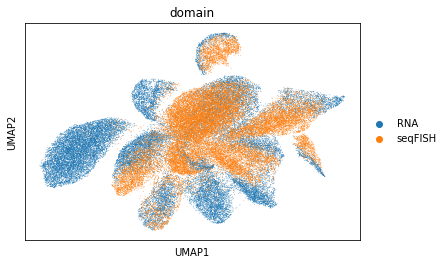

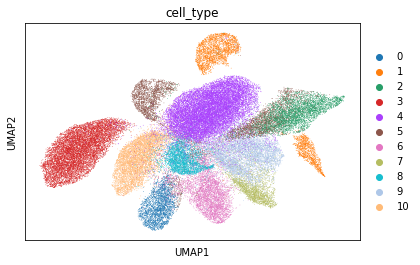

In [26]:
sc.pp.neighbors(adata_z, use_rep="X")
sc.tl.umap(adata_z)
sc.pl.umap(adata_z, color="domain", show=True)
sc.pl.umap(adata_z, color="cell_type", show=True)

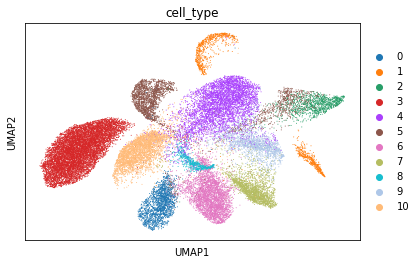

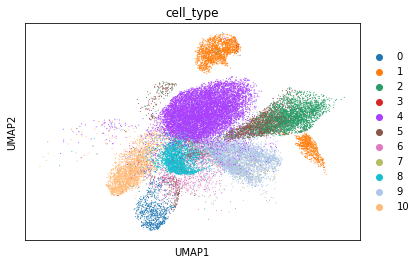

In [27]:
sc.pl.umap(adata_z[adata_z.obs["domain"]=="RNA"], color="cell_type", show=True)
sc.pl.umap(adata_z[adata_z.obs["domain"]=="seqFISH"], color="cell_type", show=True)

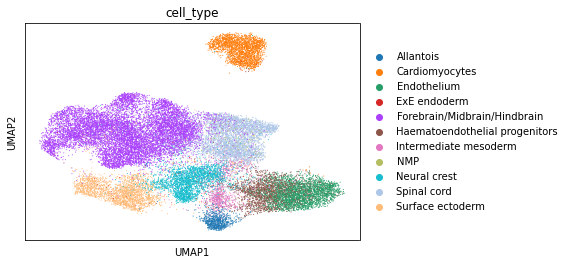

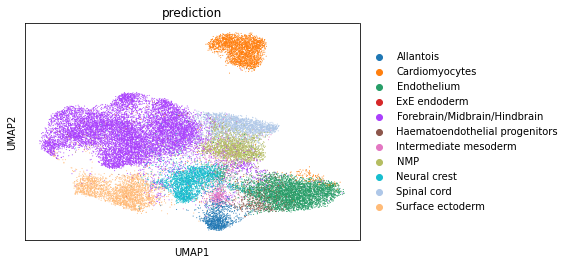

In [28]:
sc.pp.neighbors(adata_zt, use_rep="X")
sc.tl.umap(adata_zt)
sc.pl.umap(adata_zt, color="cell_type", show=True)
sc.pl.umap(adata_zt, color="prediction", show=True)

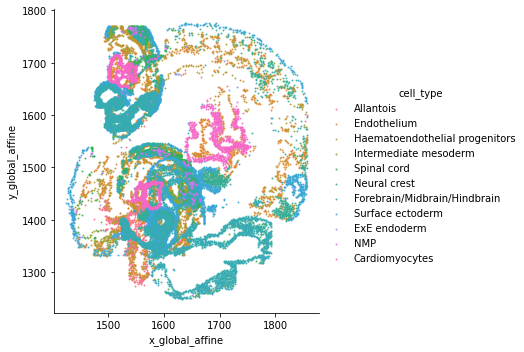

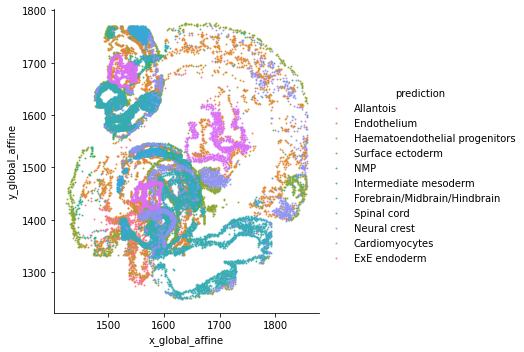

In [29]:
selected_seqfish = pd.DataFrame({'x_global_affine':target_global[:,0],'y_global_affine':target_global[:,1]})
selected_seqfish['cell_type']=np.array(truth_ct)
selected_seqfish['prediction']=np.array(pred_ct)

h5adpath = '/data/msyuan/Cross-omics-Annotator/Ablation_study_alignment_emb/save_h5ad/'
adata_z.write(h5adpath+'seqfish_spann_adata_z.h5ad')
adata_zt.write(h5adpath+'seqfish_spann_adata_zt.h5ad')
selected_seqfish.to_csv(h5adpath+'seqfish_spann_snsplot.csv')

sns.lmplot(data=selected_seqfish, x='x_global_affine', y='y_global_affine',hue='cell_type',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
sns.lmplot(data=selected_seqfish, x='x_global_affine', y='y_global_affine',hue='prediction',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})

[]

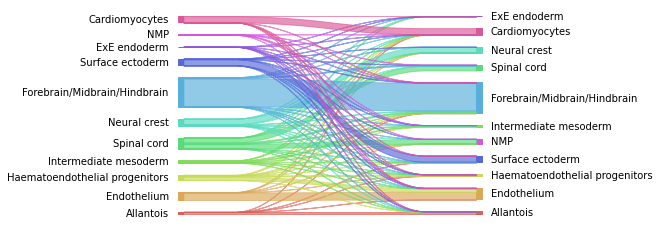

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from pysankey import sankey

sankey_df = pd.DataFrame({"cell_type":truth_ct, "predictions":pred_ct})
sky = sankey(left=sankey_df["cell_type"], right=sankey_df["predictions"], aspect=30, fontsize=10)
sky.plot()

In [31]:
savepath = '/data/msyuan/Cross-omics-Annotator/Ablation_study_alignment_emb/model_save/'
torch.save(encoder.state_dict(), savepath+'spann_encoder.pt')
torch.save(decoder.state_dict(), savepath+'spann_decoder.pt')
torch.save(classifier.state_dict(), savepath+'spann_classifier.pt')